# Modules

In [1]:
%load_ext autoreload
%autoreload 2

import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr, wilcoxon
from textwrap import wrap

from pdathome.constants import global_constants as gc, mappings as mp
from pdathome.evaluation import calculate_pvalue, plot_coefs, plot_n_subjects, plot_significance

d_plot_params = {
    'font.family': 'serif',
    'font.size': 18,
    'axes.labelsize': 20,
    'axes.titlesize': 22,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
    'legend.title_fontsize': 16,
}

sns.set(rc=d_plot_params)
sns.set_theme(style='ticks', rc=d_plot_params)

# Constants

In [2]:
step = 'gait'
l_segment_categories = ['short', 'moderately_long', 'long', 'very_long']

# Load

In [ ]:
d_performance = {
    gc.descriptives.PARKINSONS_DISEASE: {},
    gc.descriptives.CONTROLS: {}
}
for subject in gc.participant_ids.L_PD_IDS + gc.participant_ids.L_HC_IDS:
    if subject in gc.participant_ids.L_PD_IDS:
        population = gc.descriptives.PARKINSONS_DISEASE
    else:
        population = gc.descriptives.CONTROLS
    with open(os.path.join(gc.paths.PATH_OUTPUT, 'classification_performance', step, f'{subject}.json'), 'r') as f:
        
        d_performance[population][subject] = json.load(f)

with open(os.path.join(gc.paths.PATH_OUTPUT, 'feature_coefficients', step, 'logreg.json')) as f:
    d_coefs_logreg = json.load(f)

with open(os.path.join(gc.paths.PATH_OUTPUT, 'feature_coefficients', step, 'rf.json')) as f:
    d_coefs_rf = json.load(f)

# Examine performance

## Feature coefficients

Logistic regression coefficients

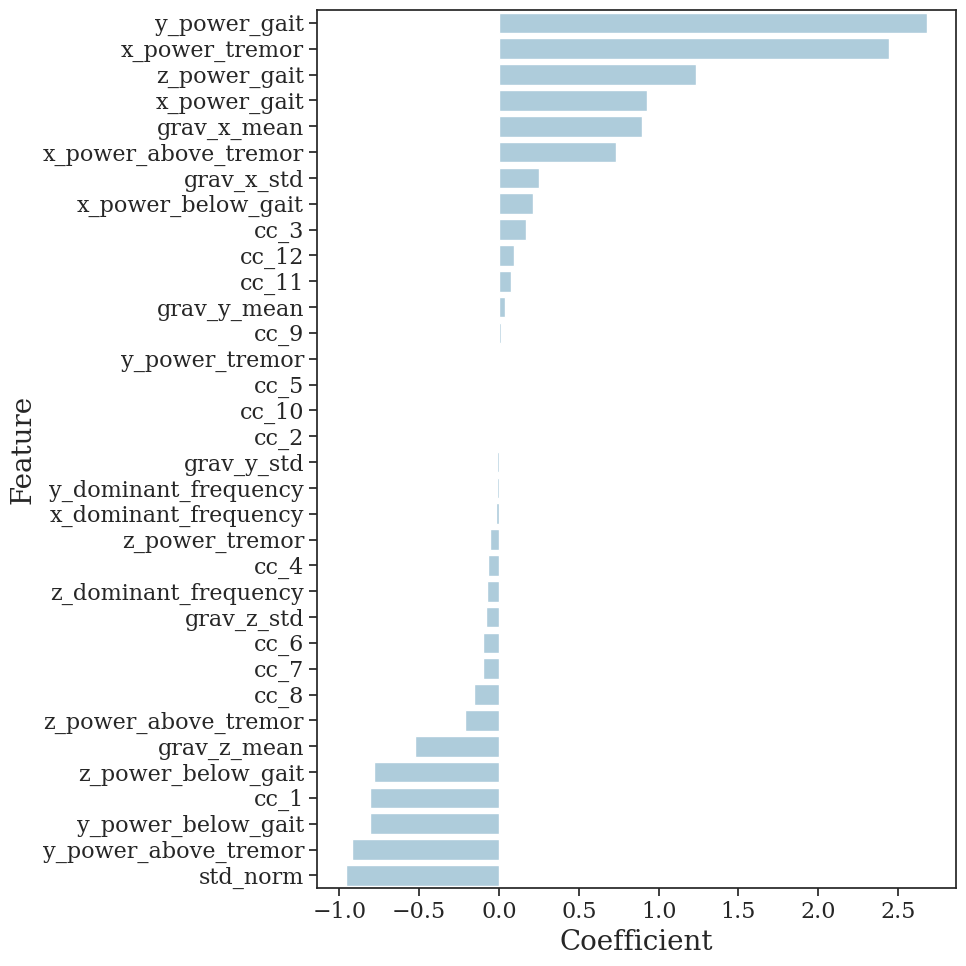

In [4]:
d_coefs_logreg = {k.replace('_accelerometer', '').replace('accelerometer_', '').replace('_acc', ''): v for k, v in d_coefs_logreg.items()}

plot_coefs(d_coefs=d_coefs_logreg, classifier=gc.classifiers.LOGISTIC_REGRESSION, figsize=(10,10))

Random forest impurity scores

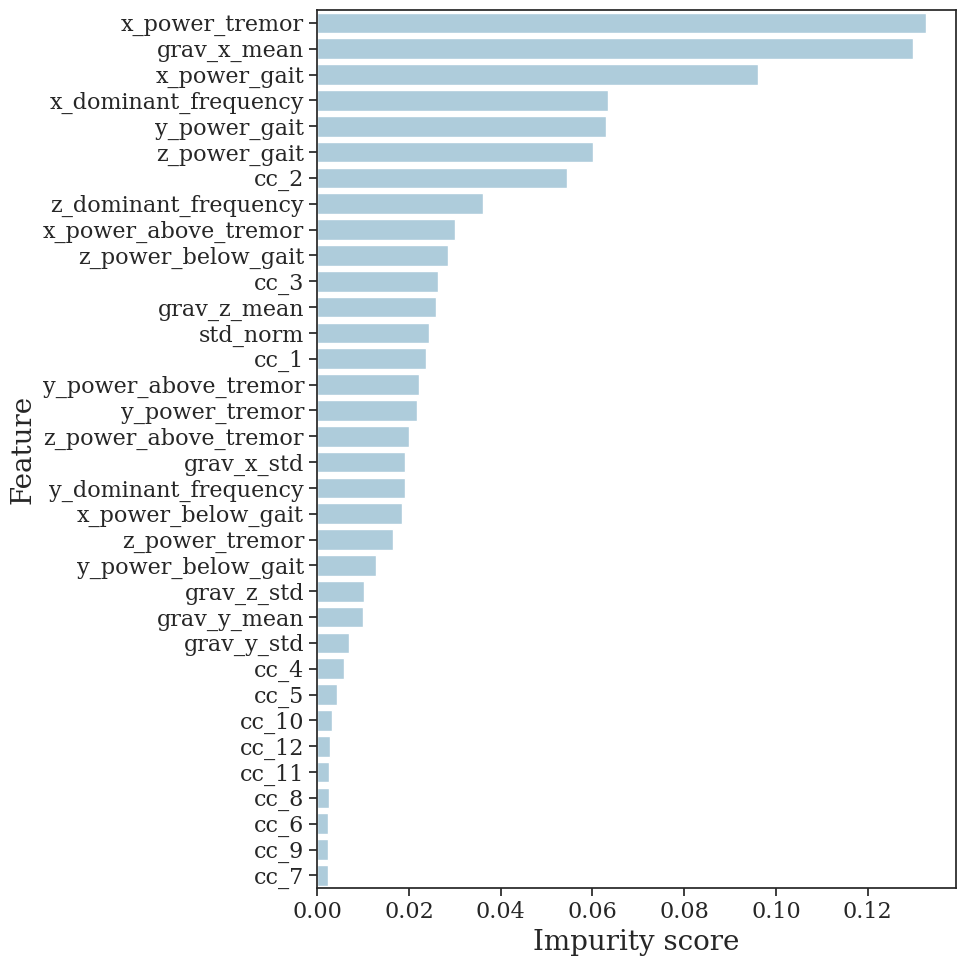

In [5]:
d_coefs_rf = {k.replace('_accelerometer', '').replace('accelerometer_', '').replace('_acc', ''): v for k, v in d_coefs_rf.items()}

plot_coefs(d_coefs=d_coefs_rf, classifier=gc.classifiers.RANDOM_FOREST, figsize=(10,10))

## Dataset size
#### Video-annotated gait

In [6]:
df_size = pd.DataFrame()

for (population, med_stage) in [(gc.descriptives.PARKINSONS_DISEASE, gc.descriptives.PRE_MED), (gc.descriptives.PARKINSONS_DISEASE, gc.descriptives.POST_MED), (gc.descriptives.CONTROLS, gc.descriptives.CONTROLS)]:
    if population == gc.descriptives.PARKINSONS_DISEASE:
        l_ids = gc.participant_ids.L_PD_IDS
    else:
        l_ids = gc.participant_ids.L_HC_IDS

    for subject in l_ids:
        for segment_duration in [x for x in list(d_performance[population][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'].keys()) if x != 'non_gait']:
            segment_duration_minutes = d_performance[population][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration]['minutes_true']

            df_size = pd.concat([df_size, pd.DataFrame([
                population,
                med_stage,
                subject,
                'pos',
                segment_duration,
                segment_duration_minutes
            ]).T], axis=0).reset_index(drop=True)

        for activity in ['pos', 'neg']:

            total_minutes = d_performance[population][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['size'][f'ann_{activity}_s']/60

            df_size = pd.concat([df_size, pd.DataFrame([
                population,
                med_stage,
                subject,
                activity,
                'total',
                total_minutes
            ]).T], axis=0).reset_index(drop=True)


df_size.columns = ['pop', 'med_stage', 'id', 'activity', 'segment_duration', 'minutes']   

df_size_grouped = df_size.groupby(['pop', 'med_stage', 'activity', 'segment_duration'])['minutes'].agg(['mean', 'std']).reset_index()

df_size_grouped['minutes_agg'] = df_size_grouped.apply(lambda x: f"{np.round(x['mean'],2)} ({np.round(x['std'],2)})", axis=1)
df_size_grouped['pop'] = df_size_grouped.apply(lambda x: f"{x['pop']} {x['med_stage']}" if x['pop'] == gc.descriptives.PARKINSONS_DISEASE else x['pop'], axis=1)

df_size_grouped = df_size_grouped.drop(columns=['mean', 'std', 'med_stage']).reset_index(drop=True)

df_size_grouped['pop'] = pd.Categorical(df_size_grouped['pop'], ['PD pre', 'PD post', 'HC'])
df_size_grouped['segment_duration'] = pd.Categorical(df_size_grouped['segment_duration'], list(mp.segment_map.values()) + ['total'])

df_size_grouped = df_size_grouped.sort_values(['pop', 'segment_duration']).reset_index(drop=True)

df_size_grouped.columns = ['Population', 'Annotated activity', 'Annotated segment duration', 'Mean (SD) number of minutes']

print(f"Minutes of annotated gait stratified by annotated segment duration.")
df_size_grouped.set_index(['Population', 'Annotated activity', 'Annotated segment duration'])

Minutes of annotated gait stratified by annotated segment duration.


Mean (SD) number of minutes
Population Annotated activity Annotated segment duration                            
PD pre     pos                short                                      0.87 (0.46)
                              moderately_long                             1.78 (0.8)
                              long                                       1.91 (0.87)
                              very_long                                  9.17 (5.67)
           neg                total                                    78.24 (15.18)
           pos                total                                      13.73 (5.8)
PD post    pos                short                                      0.54 (0.32)
                              moderately_long                            1.22 (0.52)
                              long                                        1.1 (0.65)
                              very_long                                  8.63 (5.39)
           neg                total                                     45.9 (16.26)
           pos                total                                      11.4 (5.65)
HC         pos                short                                       1.7 (0.64)
                              moderately_long                            2.29 (0.76)
                              long                                       1.76 (1.38)
                              very_long                                 14.32 (5.53)
           neg                total                                    74.74 (15.55)
           pos                total                                     20.07 (6.56)

#### Predicted gait

In [7]:
df_size = pd.DataFrame()

for (population, med_stage) in [(gc.descriptives.PARKINSONS_DISEASE, gc.descriptives.PRE_MED), (gc.descriptives.PARKINSONS_DISEASE, gc.descriptives.POST_MED), (gc.descriptives.CONTROLS, gc.descriptives.CONTROLS)]:
    if population == gc.descriptives.PARKINSONS_DISEASE:
        l_ids = gc.participant_ids.L_PD_IDS
    else:
        l_ids = gc.participant_ids.L_HC_IDS

    for subject in l_ids:
        for segment_duration in d_performance[population][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'].keys():
            segment_duration_minutes = d_performance[population][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration]['minutes_pred']

            df_size = pd.concat([df_size, pd.DataFrame([
                population,
                med_stage,
                subject,
                'pos',
                segment_duration,
                segment_duration_minutes
            ]).T], axis=0).reset_index(drop=True)

        for activity in ['pos', 'neg']:
            total_minutes = d_performance[population][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['size'][f'pred_{activity}_s']/60

            df_size = pd.concat([df_size, pd.DataFrame([
                population,
                med_stage,
                subject,
                activity,
                'total',
                total_minutes
            ]).T], axis=0).reset_index(drop=True)

df_size.columns = ['pop', 'med_stage', 'id', 'activity', 'segment_duration', 'minutes']   

df_size_grouped = df_size.groupby(['pop', 'med_stage', 'activity', 'segment_duration'])['minutes'].agg(['mean', 'std']).reset_index()

df_size_grouped['minutes_agg'] = df_size_grouped.apply(lambda x: f"{np.round(x['mean'],2)} ({np.round(x['std'],2)})", axis=1)
df_size_grouped['pop'] = df_size_grouped.apply(lambda x: f"{x['pop']} {x['med_stage']}" if x['pop'] == gc.descriptives.PARKINSONS_DISEASE else x['pop'], axis=1)

df_size_grouped = df_size_grouped.drop(columns=['mean', 'std', 'med_stage']).reset_index(drop=True)

df_size_grouped['pop'] = pd.Categorical(df_size_grouped['pop'], ['PD pre', 'PD post', 'HC'])
df_size_grouped['segment_duration'] = pd.Categorical(df_size_grouped['segment_duration'], list(mp.segment_map.values()) + ['total'])

df_size_grouped = df_size_grouped.sort_values(['pop', 'segment_duration']).reset_index(drop=True)

df_size_grouped.columns = ['Population', 'Activity', 'Annotated segment duration', 'Mean (SD) number of minutes']

print(f"Minutes of predicted gait stratified by annotated segment duration.")
df_size_grouped.set_index(['Population', 'Annotated segment duration'])

Minutes of predicted gait stratified by annotated segment duration.


Activity Mean (SD) number of minutes
Population Annotated segment duration                                     
PD pre     non_gait                        pos                 4.23 (2.45)
           short                           pos                 0.55 (0.35)
           moderately_long                 pos                 1.47 (0.75)
           long                            pos                  1.5 (0.78)
           very_long                       pos                 8.81 (5.76)
           total                           neg                75.41 (14.2)
           total                           pos                16.56 (6.52)
PD post    non_gait                        pos                 3.81 (2.62)
           short                           pos                 0.41 (0.28)
           moderately_long                 pos                 1.08 (0.51)
           long                            pos                 1.01 (0.64)
           very_long                       pos                 8.55 (5.42)
           total                           neg               42.54 (15.48)
           total                           pos                14.76 (7.14)
HC         non_gait                        pos                12.14 (6.31)
           short                           pos                 1.38 (0.52)
           moderately_long                 pos                 2.02 (0.64)
           long                            pos                 1.57 (1.28)
           very_long                       pos                14.22 (5.49)
           total                           neg               63.49 (15.41)
           total                           pos               31.32 (10.04)

## General performance
Split by population (PD, HC) and medication state for PD (pre-med, post-med)

In [8]:
df_performance = pd.DataFrame()

for gd_model in [gc.classifiers.LOGISTIC_REGRESSION, gc.classifiers.RANDOM_FOREST]:
    for (pop, med_stage) in [(gc.descriptives.PARKINSONS_DISEASE, 'pre'), (gc.descriptives.PARKINSONS_DISEASE, 'post'), (gc.descriptives.CONTROLS, gc.descriptives.CONTROLS)]:
        if pop == gc.descriptives.PARKINSONS_DISEASE:
            l_subjects = gc.participant_ids.L_PD_IDS
            pop_medstage = f"{pop}_{med_stage}"
        else:
            l_subjects = gc.participant_ids.L_HC_IDS
            pop_medstage = pop

        sens = [d_performance[pop][x][gd_model][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['sens'] for x in l_subjects]
        spec = [d_performance[pop][x][gd_model][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['spec'] for x in l_subjects]
        bacc = [(x+y)/2 for x,y in zip(sens, spec)]
        auc = [d_performance[pop][x][gd_model][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['auc'] for x in l_subjects]

        df_performance = pd.concat([df_performance, pd.DataFrame([gd_model,
                                                                  pop_medstage,
                                                                  f"{np.round(np.mean(bacc),2)} ({np.round(np.std(bacc),2)})",
                                                                  f"{np.round(np.mean(sens),2)} ({np.round(np.std(sens),2)})",
                                                                  f"{np.round(np.mean(spec),2)} ({np.round(np.std(spec),2)})",
                                                                  f"{np.round(np.mean(auc),2)} ({np.round(np.std(auc),2)})"
                                                                 ]).T], axis=0).reset_index(drop=True)
        
            
df_performance.columns = ['Classifier', 'Population', 'Balanced accuracy', 'Sensitivity', 'Specificity', 'AUC']

for med_stage in ['pre', 'post']:
    rf_bacc = [(d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['sens'] + d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['spec'])/2 for x in gc.participant_ids.L_PD_IDS]
    logreg_bacc = [(d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.LOGISTIC_REGRESSION][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['sens'] + d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.LOGISTIC_REGRESSION][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['spec'])/2 for x in gc.participant_ids.L_PD_IDS]

    print(f"*PD {med_stage}-med* random forest vs. logistic regression balanced accuracy: p = {wilcoxon(rf_bacc, logreg_bacc)[1]}")

df_performance.pivot(index='Population', columns='Classifier', values=['Sensitivity', 'Specificity', 'AUC']).sort_index(ascending=False)

*PD pre-med* random forest vs. logistic regression balanced accuracy: p = 8.058547973632812e-05
*PD post-med* random forest vs. logistic regression balanced accuracy: p = 0.0005927085876464844


Sensitivity               Specificity                       AUC  \
Classifier       logreg           rf       logreg           rf       logreg   
Population                                                                    
PD_pre      0.83 (0.09)  0.88 (0.09)  0.96 (0.02)  0.95 (0.03)  0.98 (0.02)   
PD_post     0.88 (0.08)  0.95 (0.05)  0.94 (0.04)  0.92 (0.05)  0.98 (0.01)   
HC          0.91 (0.04)  0.96 (0.02)  0.88 (0.07)  0.84 (0.09)  0.97 (0.01)   

                         
Classifier           rf  
Population               
PD_pre      0.98 (0.01)  
PD_post     0.98 (0.01)  
HC          0.98 (0.01)

In [9]:
for med_stage in ['pre']:
    rf_bacc = [(d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['sens'] + d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['spec'])/2 for x in gc.participant_ids.L_PD_IDS]
    logreg_bacc = [(d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.LOGISTIC_REGRESSION][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['sens'] + d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.LOGISTIC_REGRESSION][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['spec'])/2 for x in gc.participant_ids.L_PD_IDS]


## Effect of behavior

Effect of activities on the specificity of the classifier

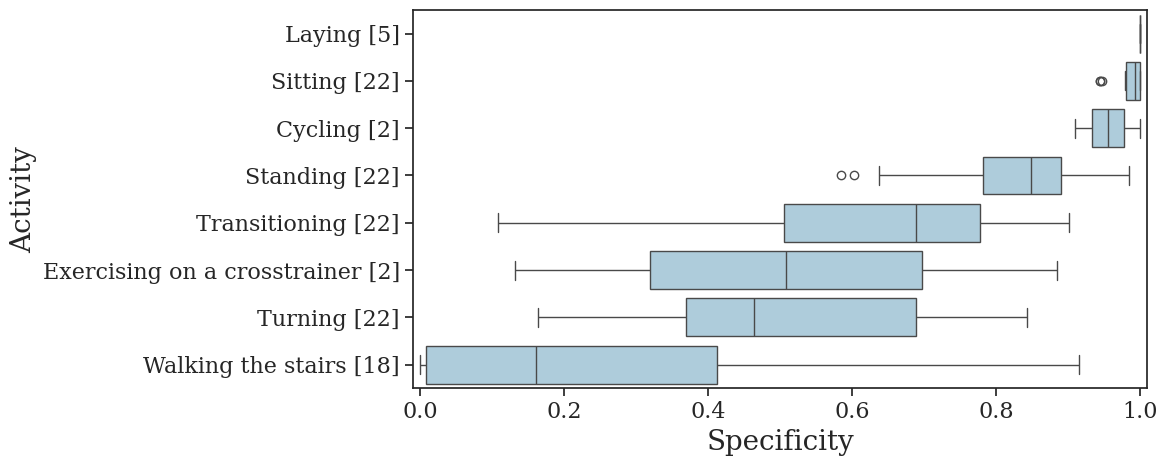

In [10]:
l_activities = list(set([x for y in [list(d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['activities'].keys()) for x in gc.participant_ids.L_PD_IDS] for x in y if x != 'Walking']))

d_activity_performance = {}

for activity in l_activities:
    d_activity_performance[activity] = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['activities'][activity]['spec'] for x in gc.participant_ids.L_PD_IDS if activity in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['activities']]

    # print(f"{activity}: {np.round(np.mean(d_activity_performance[activity]),2)} +/- {np.round(np.std(d_activity_performance[activity]),2)}")

d_activity_performance = {f'{k} [{len(d_activity_performance[k])}]': v for k, v in sorted(d_activity_performance.items(), key=lambda item: np.median(item[1]), reverse=True)}

fig, ax = plt.subplots(figsize=(12, 5))

sns.boxplot(data=d_activity_performance, ax=ax, color=gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR, orient='h')

# plot_n_subjects(d_performance=d_activity_performance, x_loc=1.015, y_loc=1.2, ax=ax)

ax.set_xlim([-0.01, 1.01])
ax.set_xlabel('Specificity')
ax.set_ylabel('Activity')
# 'Specificity of activities')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Effect of arm activities during gait on the sensitivity of the classifier

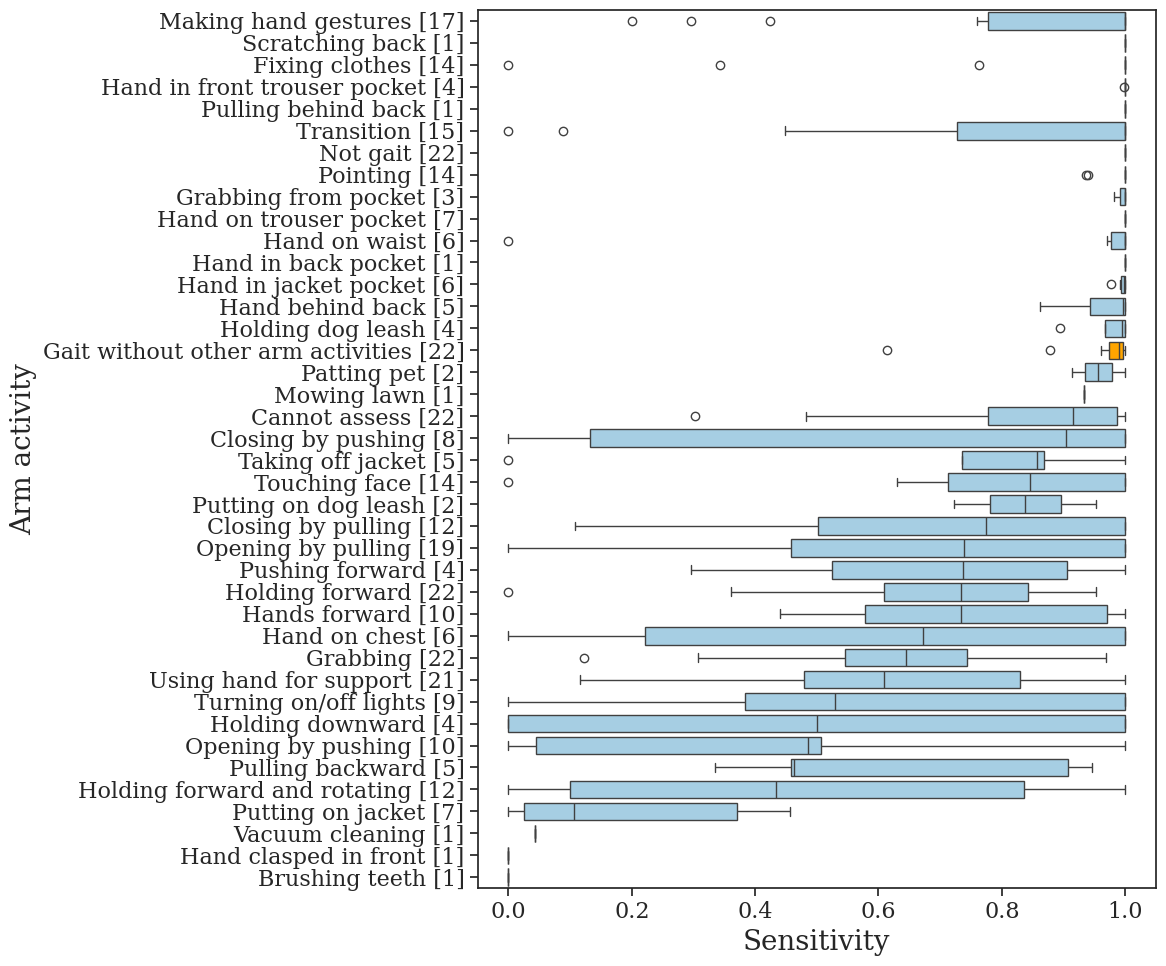

In [11]:
l_arm_activities = list(set([x for y in [list(d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['arm_activities'].keys()) for x in gc.participant_ids.L_PD_IDS] for x in y]))

d_arm_activity_performance = {}

for arm_activity in l_arm_activities:
    l_sens = [
        d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['arm_activities'][arm_activity]['sens'] 
        for x in gc.participant_ids.L_PD_IDS 
        if arm_activity in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['arm_activities']]
    
    if arm_activity == 'Gait without other arm movements':
        arm_activity = 'Gait without other arm activities'

    d_arm_activity_performance[arm_activity] = l_sens

d_arm_activity_performance = {k: v for k, v in sorted(d_arm_activity_performance.items(), key=lambda item: np.median(item[1]), reverse=True)}

# Find the index of the label to color
target_label = "Gait without other arm activities"
target_index = list(d_arm_activity_performance.keys()).index(target_label)

d_arm_activity_performance = {f'{k} [{len(d_arm_activity_performance[k])}]': v for k, v in d_arm_activity_performance.items()}

fig, ax = plt.subplots(figsize=(12, 10))

boxplot = sns.boxplot(data=d_arm_activity_performance, ax=ax, orient='h')

# Get the index of the target label and set box color
for i, patch in enumerate(ax.patches):
    if i == target_index:
        patch.set_facecolor('orange')
    else:
        patch.set_facecolor(gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR)

# plot_n_subjects(d_performance=d_arm_activity_performance, x_loc=1.015, y_loc=1.4, ax=ax)

# ax.set_xlim([-0.01, 1.01])
ax.set_xlabel('Sensitivity')
ax.set_ylabel('Arm activity')
# ax.set_title('Sensitivity of arm activities')

plt.tight_layout()
plt.show()

Effect of gait sequence duration on the sensitivity of the classifier

Sensitivity per Segment duration
short: 0.64 +/- 0.18
moderately_long: 0.81 +/- 0.12
long: 0.76 +/- 0.19
very_long: 0.95 +/- 0.14


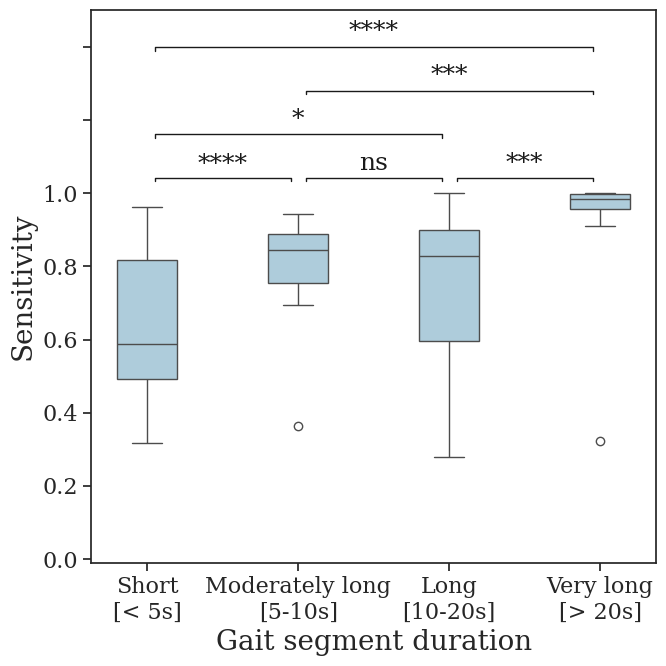

In [12]:
new_xtick_labels = [mp.segment_rename[x].replace(' [', '\n[') for x in l_segment_categories]

d_segment_performance = {}

d_segment_classes = {
    '0': 'short',
    '1': 'moderately_long',
    '2': 'long',
    '3': 'very_long',
}

d_comparisons_per_row = {
    '1': [[0, 1], [1, 2], [2, 3]],
    '2': [[0, 2]],
    '3': [[1, 3]],
    '4': [[0, 3]]
}

print("Sensitivity per Segment duration")
for segment_duration in l_segment_categories:
    d_segment_performance[segment_duration] = [
        d_performance[gc.descriptives.PARKINSONS_DISEASE][x]
        [gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED]
        [gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]
        [f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration]['sens'] 
        for x in gc.participant_ids.L_PD_IDS 
        if segment_duration in (
            d_performance[gc.descriptives.PARKINSONS_DISEASE][x]
            [gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED]
            [gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]
            [f'{gc.columns.TRUE_SEGMENT_CAT}_duration'].keys()
        )
    ]

    print(f"{segment_duration}: {np.round(np.mean(d_segment_performance[segment_duration]),2)} +/- {np.round(np.std(d_segment_performance[segment_duration]),2)}")

fig, ax = plt.subplots(figsize=(7,7))

sns.boxplot(data=d_segment_performance, width=0.4, ax=ax, color=gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR)

for row, comparisons in d_comparisons_per_row.items():
    for comparison in comparisons:
        vals_1 = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][d_segment_classes[str(comparison[0])]]['sens'] for x in gc.participant_ids.L_PD_IDS]
        vals_2 = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][d_segment_classes[str(comparison[1])]]['sens'] for x in gc.participant_ids.L_PD_IDS]
        pvalue = calculate_pvalue(vals_1, vals_2, 'wilcoxon')[1]
        plot_significance(ax, comparison[0]+0.05, comparison[1]-0.05, pvalue, 1, 0.12, int(row), d_plot_params['font.size'])


ax.set_ylim([-0.01, 1.5])
ax.set_ylabel('Sensitivity')
ax.set_xlabel('Gait segment duration')
# ax.set_title('Gait detection sensitivity\nper Segment duration')
ax.set_xticks(ax.get_xticks(), new_xtick_labels)

for i in range(1,4):
    ax.yaxis.get_major_ticks()[-1*i].label1.set_visible(False)

# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Effect of gait sequence duration on differences between PD pre-med and post-med in sensitivity of the classifier

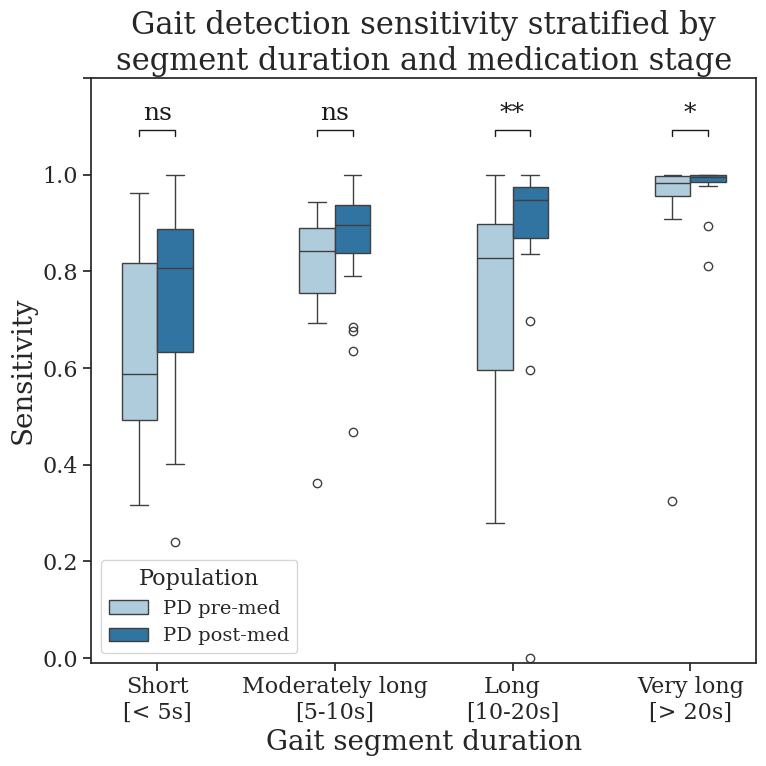

In [13]:
new_xtick_labels = [mp.segment_rename[x].replace(' [', '\n[') for x in l_segment_categories]

d_stages = {
    '0': 'PD pre-med', 
    '1': 'PD post-med', 
    '2': 'Conrols',
}

d_comparisons_per_row = {
    '1': [[0, 1], [1, 2]],
    '2': [[0, 2]]
}


df_seq = pd.DataFrame()
for segment_duration in l_segment_categories:
    for med_stage in [gc.descriptives.PRE_MED, gc.descriptives.POST_MED]:
        d_seq_performance = [
            d_performance[gc.descriptives.PARKINSONS_DISEASE][x]
            [gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED]
            [gc.descriptives.MOST_AFFECTED_SIDE][med_stage]
            [f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration]['sens'] 
            for x in gc.participant_ids.L_PD_IDS 
            if segment_duration in (
                d_performance[gc.descriptives.PARKINSONS_DISEASE][x]
                [gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED]
                [gc.descriptives.MOST_AFFECTED_SIDE][med_stage]
                [f'{gc.columns.TRUE_SEGMENT_CAT}_duration'].keys()
            )
        ]
        
        med_stage_label = f'PD {med_stage}-med'
        df_seq = pd.concat([
            df_seq,
            pd.DataFrame([
                d_seq_performance,
                np.repeat(segment_duration, len(d_seq_performance)),
                np.repeat(med_stage_label, len(d_seq_performance))], index=['sens', 'segment_duration', 'med_stage']
                ).T])
        
fig, ax = plt.subplots(figsize=(8, 8))

sns.boxplot(data=df_seq, x='segment_duration', y='sens', hue='med_stage', width=0.4, ax=ax, palette='Paired')

for j, segment_duration in enumerate(l_segment_categories):
    l_valid_pd_ids = [x for x in gc.participant_ids.L_PD_IDS if segment_duration in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'].keys() and segment_duration in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.POST_MED][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'].keys()]

    vals_pre = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration]['sens'] for x in l_valid_pd_ids]
    vals_post = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.POST_MED][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration]['sens'] for x in l_valid_pd_ids]
    
    pvalue = calculate_pvalue(vals_pre, vals_post, 'wilcoxon')[1]
    plot_significance(ax, j-0.1, j+0.1, pvalue, 1.05, 0.09, 1, d_plot_params['font.size'])

ax.set_ylim([-0.01, 1.2])
ax.set_ylabel('Sensitivity')
ax.set_xlabel('Gait segment duration')
ax.set_xticks(ax.get_xticks(), new_xtick_labels)
ax.set_title('Gait detection sensitivity stratified by\nsegment duration and medication stage')
ax.legend(title='Population')

for i in range(1,2):
    ax.yaxis.get_major_ticks()[-1*i].label1.set_visible(False)

# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

PD pre-med vs post-med after correcting for sequence duration and arm activities

System: uncorrected - p-value: 4.1961669921875e-05
System: corrected - p-value: 0.8736042976379395


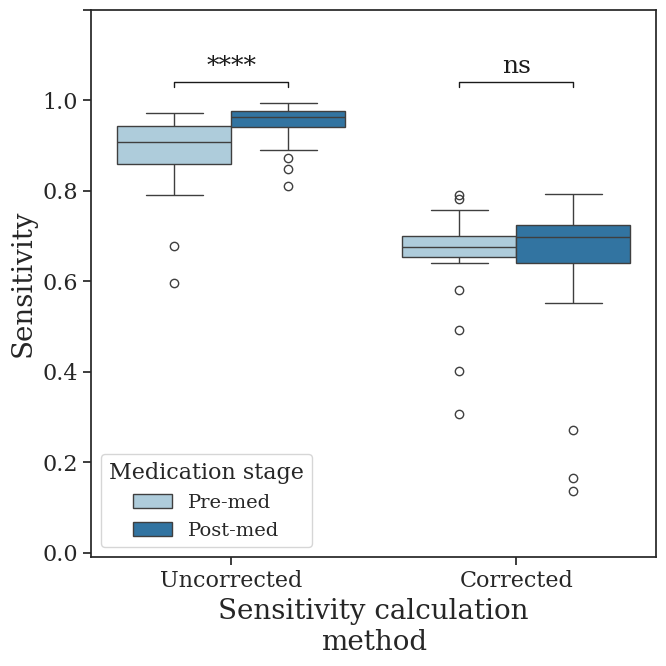

In [15]:
df_arm_activity = pd.DataFrame()
df_uncorrected = pd.DataFrame()

# Collect data for each subject
for subject in gc.participant_ids.L_PD_IDS:
    for med_stage in ['pre', 'post']:
        for segment_duration in mp.segment_rename.keys():
            try:
                d_focus = d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration]
            except KeyError:
                continue
            else:
                for arm_activity in d_focus['arm_activities'].keys():
                    mins = d_focus['arm_activities'][arm_activity]['minutes']
                    sens = d_focus['arm_activities'][arm_activity]['sens']
                    df_arm_activity = pd.concat([df_arm_activity, pd.DataFrame([mins, sens, segment_duration, arm_activity, subject, med_stage], 
                                              index=['mins', 'sens', f'{gc.columns.TRUE_SEGMENT_CAT}_duration', gc.columns.ARM_LABEL, gc.columns.ID, gc.columns.PRE_OR_POST]).T])
        
        sens_uncorrected = d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['sens']
        df_uncorrected = pd.concat([df_uncorrected, pd.DataFrame([sens_uncorrected, subject, med_stage]).T])

df_uncorrected.columns = ['sens', gc.columns.ID, gc.columns.PRE_OR_POST]
df_uncorrected['system'] = 'uncorrected'

# Calculate corrected sensitivities
df_corrected_sens = df_arm_activity.copy()

# Calculate corrected prevalence
df_corrected_prevalence = df_arm_activity.groupby([gc.columns.ARM_LABEL, f'{gc.columns.TRUE_SEGMENT_CAT}_duration'])['mins'].sum().reset_index()
df_corrected_prevalence['prop_corrected'] = df_corrected_prevalence['mins'] / df_corrected_prevalence['mins'].sum()

# Merge corrected prevalence into corrected sensitivities
df_corrected = df_corrected_sens.merge(df_corrected_prevalence[[gc.columns.ARM_LABEL, f'{gc.columns.TRUE_SEGMENT_CAT}_duration', 'prop_corrected']], 
                                            how='left', 
                                            on=[gc.columns.ARM_LABEL, f'{gc.columns.TRUE_SEGMENT_CAT}_duration'])

# Initialize dataframe containing corrected and uncorrected values
df_complete = pd.DataFrame()

# Calculate sensitivity for the corrected method
for stage in ['pre', 'post']:
    df_stage = df_corrected.loc[df_corrected[gc.columns.PRE_OR_POST] == stage]
    for subject in gc.participant_ids.L_PD_IDS:
        df_subject = df_stage.loc[df_stage[gc.columns.ID] == subject]
        if df_subject.shape[0] > 0:
            # Uncorrected sensitivities
            uncorrected_sens = df_uncorrected.loc[(df_uncorrected[gc.columns.PRE_OR_POST] == stage) & (df_uncorrected[gc.columns.ID] == subject), 'sens'].values
            uncorrected_entry = pd.DataFrame([[stage, subject, 'uncorrected', np.mean(uncorrected_sens) if uncorrected_sens.size > 0 else 0]], 
                                       columns=[gc.columns.PRE_OR_POST, gc.columns.ID, 'system', 'sens'])
            df_complete = pd.concat([df_complete, uncorrected_entry], ignore_index=True)

            # Corrected sensitivity calculation
            corrected_sens = np.sum(np.multiply(df_subject['sens'], df_subject['prop_corrected']))
            corrected_entry = pd.DataFrame([[stage, subject, 'corrected', corrected_sens]], 
                                           columns=[gc.columns.PRE_OR_POST, gc.columns.ID, 'system', 'sens'])
            df_complete = pd.concat([df_complete, corrected_entry], ignore_index=True)

# Set column names for df_corrected
df_complete.columns = [gc.columns.PRE_OR_POST, gc.columns.ID, 'system', 'sens']

# Drop IDs that are missing either pre or post
l_drop_ids = [x for x in df_complete.loc[df_complete[gc.columns.PRE_OR_POST] == 'pre', gc.columns.ID].unique() if x not in df_complete.loc[df_complete[gc.columns.PRE_OR_POST] == 'post', gc.columns.ID].unique()]
df_complete = df_complete.loc[~df_complete[gc.columns.ID].isin(l_drop_ids)]

# Plotting
fig, ax = plt.subplots(figsize=(7,7))

# Define the order for systems
order = ['uncorrected', 'corrected']

sns.boxplot(data=df_complete, x='system', y='sens', hue=gc.columns.PRE_OR_POST, order=order, palette=gc.plot_parameters.COLOR_PALETTE)

for j, system in enumerate(order):
    vals_pre = list(df_complete.loc[(df_complete['system'] == system) & (df_complete[gc.columns.PRE_OR_POST] == 'pre'), 'sens'].values)
    vals_post = list(df_complete.loc[(df_complete['system'] == system) & (df_complete[gc.columns.PRE_OR_POST] == 'post'), 'sens'].values)

    # Assuming calculate_pvalue and plot_significance are functions already defined
    pvalue = calculate_pvalue(vals_pre, vals_post, 'wilcoxon')[1]
    plot_significance(ax=ax, x_min=j + 0.2, x_max=j - 0.2, pvalue=pvalue, y_min_significance=1, gap=0.01, row=1, text_size=d_plot_params['font.size'])

    print(f"System: {system} - p-value: {pvalue}")

ax.set_ylim([-0.01, 1.2])
ax.set_xticks(ax.get_xticks(), ['Uncorrected', 'Corrected'])
# ax.set_title('Sensitivity with and without correction')
ax.set_xlabel('Sensitivity calculation\nmethod')
ax.set_ylabel('Sensitivity')

# Customize legend and axis tick visibility
ax.legend(handles=ax.get_legend_handles_labels()[0], labels=['Pre-med', 'Post-med'], title='Medication stage')

for j in range(1, 2):
    ax.yaxis.get_major_ticks()[-1 * j].label1.set_visible(False)

fig.tight_layout()
plt.show()


System: uncorrected - p-value: 0.00023476005406353293
System: corrected - p-value: 0.0004325304344443779


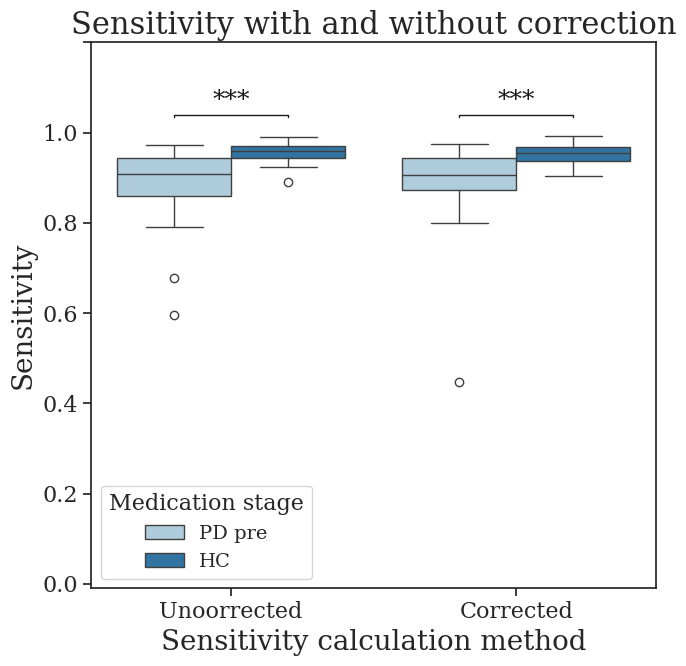

In [40]:
# Initialize dataframe to collect data for both PD and Controls
df_comparison = pd.DataFrame()
df_uncorrected = pd.DataFrame()
pd_med_stage = gc.descriptives.PRE_MED

# Collect data for PD participants
for subject in gc.participant_ids.L_PD_IDS:
    for segment_duration in mp.segment_rename.keys():
        try:
            d_focus = d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][pd_med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration]
        except KeyError:
            continue
        else:
            mins = d_focus['minutes_true']
            sens = d_focus['sens']
            df_comparison = pd.concat([df_comparison, pd.DataFrame([[mins, sens, segment_duration, subject, pd_med_stage]], 
                                       columns=['mins', 'sens', f'{gc.columns.TRUE_SEGMENT_CAT}_duration', gc.columns.ID, gc.columns.PRE_OR_POST])])
            
    df_uncorrected = pd.concat([df_uncorrected, pd.DataFrame([[d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][pd_med_stage]['sens'], subject, gc.descriptives.PARKINSONS_DISEASE]])])

# Collect data for Healthy Controls (only for segment duration)
for subject in gc.participant_ids.L_HC_IDS:
    for segment_duration in mp.segment_rename.keys():
        try:
            d_focus = d_performance[gc.descriptives.CONTROLS][subject][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.CONTROLS][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration]
        except KeyError:
            continue
        else:
            # Only accumulate total minutes for controls (no arm activities)
            total_mins = d_focus['minutes_true']  
            sens = d_focus['sens']
            df_comparison = pd.concat([df_comparison, pd.DataFrame([[total_mins, sens, segment_duration, subject, gc.descriptives.CONTROLS]], 
                                              columns=['mins', 'sens', f'{gc.columns.TRUE_SEGMENT_CAT}_duration', gc.columns.ID, gc.columns.PRE_OR_POST])])
            
    df_uncorrected = pd.concat([df_uncorrected, pd.DataFrame([[d_performance[gc.descriptives.CONTROLS][subject][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.CONTROLS]['sens'], subject, gc.descriptives.CONTROLS]])])

df_uncorrected.columns = ['sens', gc.columns.ID, gc.columns.PRE_OR_POST]
df_uncorrected['system'] = 'uncorrected'

# Calculate corrected sensitivities
df_corrected_sens = df_comparison.copy()

# Calculate corrected prevalence
df_corrected_prevalence = df_comparison.groupby(f'{gc.columns.TRUE_SEGMENT_CAT}_duration')['mins'].sum().reset_index()
df_corrected_prevalence['prop_corrected'] = df_corrected_prevalence['mins'] / df_corrected_prevalence['mins'].sum()

# Merge corrected prevalence into corrected sensitivities
df_corrected = df_corrected_sens.merge(df_corrected_prevalence[[f'{gc.columns.TRUE_SEGMENT_CAT}_duration', 'prop_corrected']], 
                                            how='left', 
                                            on=[f'{gc.columns.TRUE_SEGMENT_CAT}_duration'])

# Initialize dataframe containing corrected and uncorrected values
df_complete = pd.DataFrame()

# Calculate sensitivity for the corrected method
for stage in [pd_med_stage, 'HC']:
    df_stage = df_corrected.loc[df_corrected[gc.columns.PRE_OR_POST] == stage]
    for subject in df_stage[gc.columns.ID].unique():
        df_subject = df_stage.loc[df_stage[gc.columns.ID] == subject]
        if df_subject.shape[0] > 0:
            # Uncorrected sensitivities
            uncorrected_sens = df_uncorrected.loc[df_uncorrected[gc.columns.ID] == subject, 'sens'].values
            uncorrected_entry = pd.DataFrame([[stage, subject, 'uncorrected', np.mean(uncorrected_sens) if uncorrected_sens.size > 0 else 0]], 
                                       columns=[gc.columns.PRE_OR_POST, gc.columns.ID, 'system', 'sens'])
            df_complete = pd.concat([df_complete, uncorrected_entry], ignore_index=True)

            # Corrected sensitivity calculation
            corrected_sens = np.sum(np.multiply(df_subject['sens'], df_subject['prop_corrected']))
            corrected_entry = pd.DataFrame([[stage, subject, 'corrected', corrected_sens]], 
                                           columns=[gc.columns.PRE_OR_POST, gc.columns.ID, 'system', 'sens'])
            df_complete = pd.concat([df_complete, corrected_entry], ignore_index=True)

# Set column names for df_corrected
df_complete.columns = [gc.columns.PRE_OR_POST, gc.columns.ID, 'system', 'sens']

# Plotting
fig, ax = plt.subplots(figsize=(7,7))

# Define the order for systems
order = ['uncorrected', 'corrected']

sns.boxplot(data=df_complete, x='system', y='sens', hue=gc.columns.PRE_OR_POST, order=order, palette=gc.plot_parameters.COLOR_PALETTE)

for j, system in enumerate(order):
    vals_pd = list(df_complete.loc[(df_complete['system'] == system) & (df_complete[gc.columns.PRE_OR_POST] == pd_med_stage), 'sens'].values)
    vals_hc = list(df_complete.loc[(df_complete['system'] == system) & (df_complete[gc.columns.PRE_OR_POST] == 'HC'), 'sens'].values)

    # Assuming calculate_pvalue and plot_significance are functions already defined
    pvalue = calculate_pvalue(vals_pd, vals_hc, 'ranksums')[1]
    plot_significance(ax=ax, x_min=j + 0.2, x_max=j - 0.2, pvalue=pvalue, y_min_significance=1, gap=0.01, row=1, text_size=d_plot_params['font.size'])

    print(f"System: {system} - p-value: {pvalue}")

ax.set_ylim([-0.01, 1.2])
ax.set_xticks(ax.get_xticks(), ['Unoorrected', 'Corrected'])
ax.set_title('Sensitivity with and without correction')
ax.set_xlabel('Sensitivity calculation method')
ax.set_ylabel('Sensitivity')

# Customize legend and axis tick visibility
ax.legend(handles=ax.get_legend_handles_labels()[0], labels=[f'PD {pd_med_stage}', 'HC'], title='Medication stage')

for j in range(1, 2):
    ax.yaxis.get_major_ticks()[-1 * j].label1.set_visible(False)

fig.tight_layout()
plt.show()

## Effect of PD

In [17]:
import datetime

for subject in gc.participant_ids.L_PD_IDS:
    df_patient_info = pd.read_pickle(os.path.join(gc.paths.PATH_CLINICAL_DATA, 'df_patient_info_updrs_3.pkl'))
    df_subject = df_patient_info.loc[df_patient_info['record_id']==subject]

    age = int(datetime.datetime.now().year - df_subject['year_of_birth'].iloc[0])
    ysd = int(datetime.datetime.now().year - df_subject['year_diagnosis'].iloc[0])
    gender = 'male' if df_subject['gender'].iloc[0] == 1 else 'female'

    d_clinical_scores = {}

    d_clinical_scores['updrs'] = {}
    for med_stage, med_prefix in zip([gc.descriptives.PRE_MED, gc.descriptives.POST_MED], ['OFF', 'ON']):
        d_clinical_scores['updrs'][med_stage] = {}
        for side in ['right', 'left']:
            if subject in gc.participant_ids.L_PD_MOST_AFFECTED_RIGHT:
                if side == 'right':
                    affected_side = gc.descriptives.MOST_AFFECTED_SIDE
                else:
                    affected_side = gc.descriptives.LEAST_AFFECTED_SIDE
            else:
                if side == 'left':
                    affected_side = gc.descriptives.MOST_AFFECTED_SIDE
                else:
                    affected_side = gc.descriptives.LEAST_AFFECTED_SIDE

            updrs_3_hypokinesia_stage_cols = [f'{med_prefix}_{x}' for x in mp.updrs_3_map[side]['hypokinesia'].keys()]
            updrs_3_stage_cols = updrs_3_hypokinesia_stage_cols + [f'{med_prefix}_{x}' for x in mp.updrs_3_map[side]['tremor'].keys()]
            
            d_clinical_scores['updrs'][med_stage][affected_side] = {
                'subscore': np.sum(df_subject[updrs_3_hypokinesia_stage_cols], axis=1).values[0],
                'total': np.sum(df_subject[updrs_3_stage_cols], axis=1).values[0]
            }

In [18]:
df_segment_subscore = pd.DataFrame()

for subject in gc.participant_ids.L_PD_IDS:
    subscore = d_performance[gc.descriptives.PARKINSONS_DISEASE][subject]['clinical']['updrs'][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['subscore']
    for segment_duration in [x for x in l_segment_categories if x in d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'].keys()]:
        sens = d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration]['sens']
        df_segment_subscore = pd.concat([df_segment_subscore, pd.DataFrame([subscore, segment_duration, sens, subject], index=['subscore', f'{gc.columns.TRUE_SEGMENT_CAT}_duration', 'sens', gc.columns.ID]).T])

df_segment_subscore['subscore'] = df_segment_subscore['subscore'].astype(int)
df_segment_subscore['sens'] = df_segment_subscore['sens'].astype(float)

Spearman correlation between subscore and sensitivity for ...

... Short [< 5s] segments: 0.12 (p=0.61)
... Moderately long [5-10s] segments: -0.33 (p=0.13)
... Long [10-20s] segments: 0.22 (p=0.32)
... Very long [> 20s] segments: -0.11 (p=0.61)


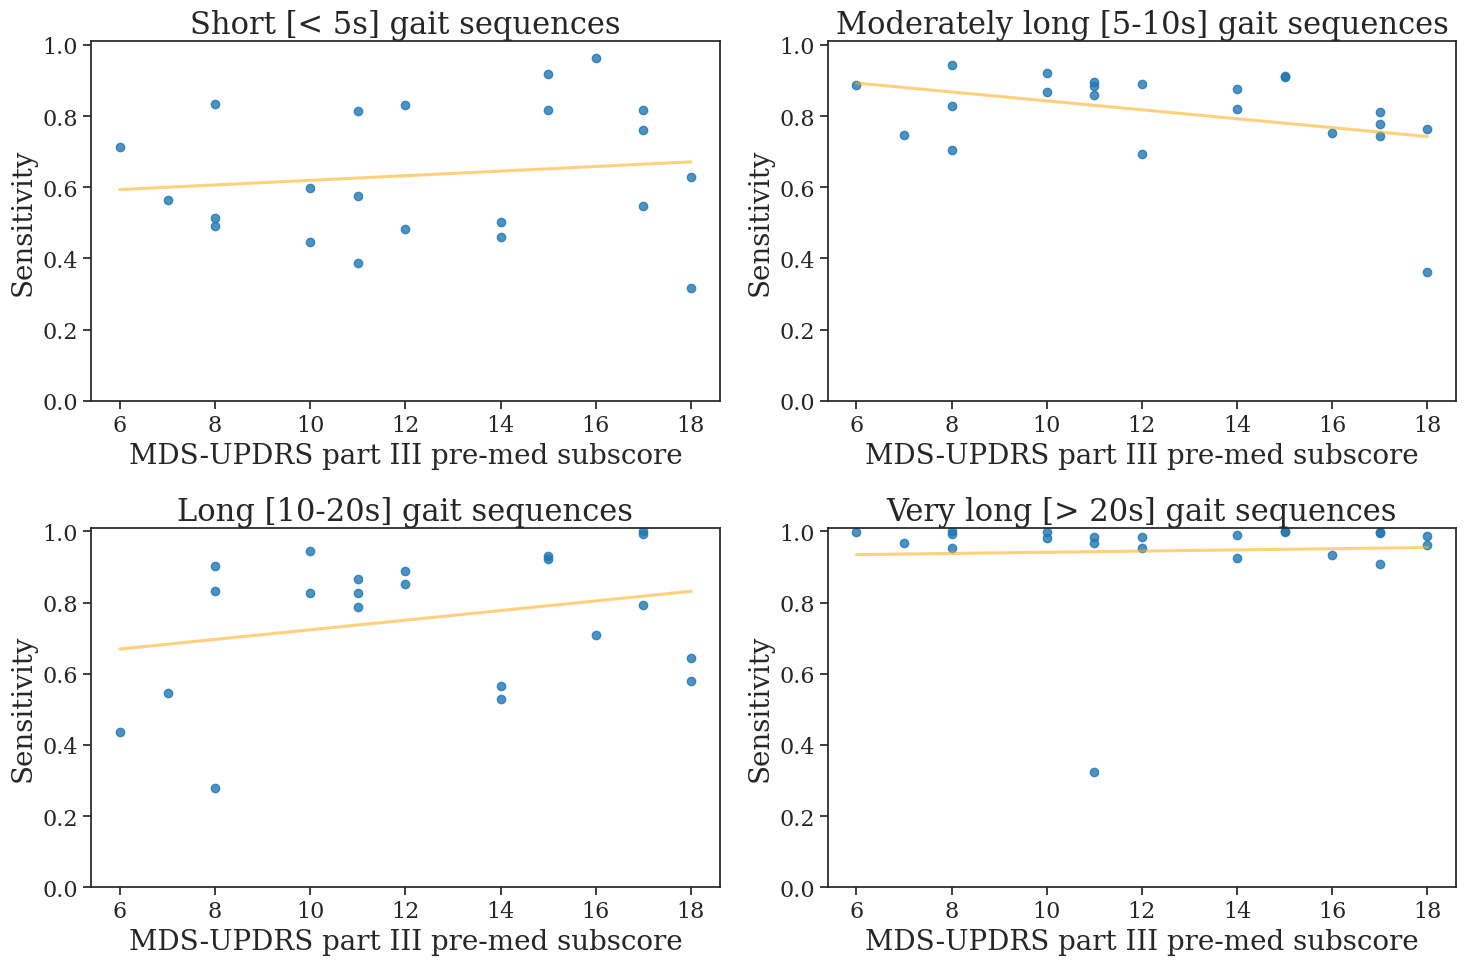

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

print("Spearman correlation between subscore and sensitivity for ...\n")
for j, segment_duration in enumerate(l_segment_categories):
    
    df_segment_specific = df_segment_subscore.loc[df_segment_subscore[f'{gc.columns.TRUE_SEGMENT_CAT}_duration']==segment_duration].reset_index(drop=True)

    sns.regplot(x='subscore', y='sens',
                data=df_segment_specific, ci=False, scatter_kws={'color': gc.plot_parameters.COLOR_PALETTE_SECOND_COLOR},
                line_kws={'color': 'orange', 'alpha': 0.5}, marker='o', label='PwP',
                ax=ax[j//2,j%2])

    rho = np.round(spearmanr(df_segment_specific['sens'], df_segment_specific['subscore']).correlation,2)
    rho_p = np.round(spearmanr(df_segment_specific['sens'], df_segment_specific['subscore']).pvalue,2)

    print(f"... {mp.segment_rename[segment_duration].replace('$', '')} segments: {rho} (p={rho_p})")

    ax[j//2,j%2].set_title(f'{mp.segment_rename[segment_duration]} gait sequences')
    ax[j//2,j%2].set_ylabel('Sensitivity')
    ax[j//2,j%2].set_xlabel(f'MDS-UPDRS part III pre-med subscore')
    ax[j//2,j%2].set_ylim([0,1.01])
        
fig.tight_layout()
plt.show()

Tremor

In [28]:
l_ids_tremor_pre = [x for x in d_performance[gc.descriptives.PARKINSONS_DISEASE].keys() if 'tremor_spec' in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED].keys() and 'no_tremor_spec' in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED].keys()]
l_ids_tremor_post = [x for x in d_performance[gc.descriptives.PARKINSONS_DISEASE].keys() if 'tremor_spec' in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.POST_MED].keys() and 'no_tremor_spec' in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.POST_MED].keys()]

d_tremor = {
    'premed_tremor': [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['tremor_spec'] for x in l_ids_tremor_pre],
    'premed_nontremor': [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['no_tremor_spec'] for x in l_ids_tremor_pre],
    'postmed_tremor': [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.POST_MED]['tremor_spec'] for x in l_ids_tremor_post],
    'postmed_nontremor': [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.POST_MED]['no_tremor_spec'] for x in l_ids_tremor_post]
}

print("Gait detection specificity during tremor vs no tremor")
print(f"P-value pre-med: {wilcoxon(d_tremor['premed_tremor'], d_tremor['premed_nontremor'])[1]}")
print(f"P-value post-med: {wilcoxon(d_tremor['postmed_tremor'], d_tremor['postmed_nontremor'])[1]}")

Gait detection specificity during tremor vs no tremor
P-value pre-med: 0.7421875
P-value post-med: 0.4375


In [30]:
df_tremor = pd.DataFrame()
l_tremor_bool = ['tremor', 'no_tremor']
d_pvals = {}

for med_stage in [gc.descriptives.PRE_MED, gc.descriptives.POST_MED]:
    l_ids_tremor = [x for x in d_performance[gc.descriptives.PARKINSONS_DISEASE].keys() if 'tremor_spec' in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage].keys() and 'no_tremor_spec' in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage].keys()]

    l_specs = []
    for tremor_bool in l_tremor_bool:
        
        spec = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage][f'{tremor_bool}_spec'] for x in l_ids_tremor]
        l_specs.append(spec)

        df_tremor = pd.concat([df_tremor, pd.DataFrame([
                                med_stage,
                                tremor_bool,
                                f"{np.round(np.mean(spec),2)} ({np.round(np.std(spec),2)})",
                                ]).T], axis=0).reset_index(drop=True)
        
    p_val = wilcoxon(l_specs[0], l_specs[1])[1]

    print(f"P-value {med_stage} gait detection specificity during tremor vs no tremor: {p_val}")
    
df_tremor.columns = ['Medication stage', 'Tremor boolean', 'Specificity']

df_tremor.pivot(index='Medication stage', columns='Tremor boolean', values=['Specificity']).sort_index(ascending=False)

P-value pre gait detection specificity during tremor vs no tremor: 0.7421875
P-value post gait detection specificity during tremor vs no tremor: 0.4375


Specificity             
Tremor boolean      no_tremor       tremor
Medication stage                          
pre               0.93 (0.05)  0.94 (0.05)
post               0.9 (0.06)   0.9 (0.11)